Data Merging and Cleaning

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.feature_selection import SelectKBest, f_classif

# Load the datasets
df_a = pd.read_csv('../data/DataA.csv')
df_b = pd.read_csv('../data/DataB.csv')

# Merge the datasets
df = pd.concat([df_a, df_b], axis=0, ignore_index=True)

# Check for missing values
print(df.isnull().sum())

# Remove columns with more than 50% missing values
df = df.dropna(axis=1, thresh=len(df)*0.5)

# Impute missing values
numeric_columns = df.select_dtypes(include=[np.number]).columns
imputer = SimpleImputer(strategy='median')
df[numeric_columns] = imputer.fit_transform(df[numeric_columns])

# Convert 'Survival' to binary (0 for death, 1 for survival)
df['Survival_binary'] = (df['Survival'] > 0).astype(int)

# Remove unnecessary columns
df = df.drop(['recordid', 'Survival', 'In-hospital_death'], axis=1)

print(df.shape)
print(df.columns)

recordid                0
SAPS-I                  0
SOFA                    0
Length_of_stay          0
Survival                0
                     ... 
pH_last              1932
MechVentStartTime    2960
MechVentDuration     2960
MechVentLast8Hour    2960
UrineOutputSum       2960
Length: 120, dtype: int64
(8000, 92)
Index(['SAPS-I', 'SOFA', 'Length_of_stay', 'Age', 'Gender', 'Height', 'Weight',
       'CCU', 'CSRU', 'SICU', 'DiasABP_first', 'GCS_first', 'Glucose_first',
       'HR_first', 'MAP_first', 'NIDiasABP_first', 'NIMAP_first',
       'NISysABP_first', 'Temp_first', 'DiasABP_last', 'GCS_last',
       'Glucose_last', 'HR_last', 'MAP_last', 'NIDiasABP_last', 'NIMAP_last',
       'NISysABP_last', 'Temp_last', 'DiasABP_lowest', 'GCS_lowest',
       'Glucose_lowest', 'HR_lowest', 'MAP_lowest', 'NIDiasABP_lowest',
       'NIMAP_lowest', 'NISysABP_lowest', 'Temp_lowest', 'DiasABP_highest',
       'GCS_highest', 'Glucose_highest', 'HR_highest', 'MAP_highest',
       'NIDiasABP_high

Exploratory Data Analysis (EDA)

            SAPS-I         SOFA  Length_of_stay          Age       Gender  \
count  8000.000000  8000.000000     8000.000000  8000.000000  8000.000000   
mean     14.243750     6.364625       13.584875    64.429750     0.563375   
std       6.044825     4.237236       12.715975    17.352628     0.495998   
min      -1.000000    -1.000000       -1.000000    15.000000     0.000000   
25%      11.000000     3.000000        6.000000    53.000000     0.000000   
50%      15.000000     6.000000       10.000000    67.000000     1.000000   
75%      18.000000     9.000000       17.000000    78.000000     1.000000   
max      34.000000    22.000000      171.000000    90.000000     1.000000   

            Height       Weight          CCU         CSRU         SICU  ...  \
count   8000.00000  8000.000000  8000.000000  8000.000000  8000.000000  ...   
mean     171.96569    81.154986     0.145875     0.207000     0.282500  ...   
std      130.93059    22.358586     0.353003     0.405181     0.45024

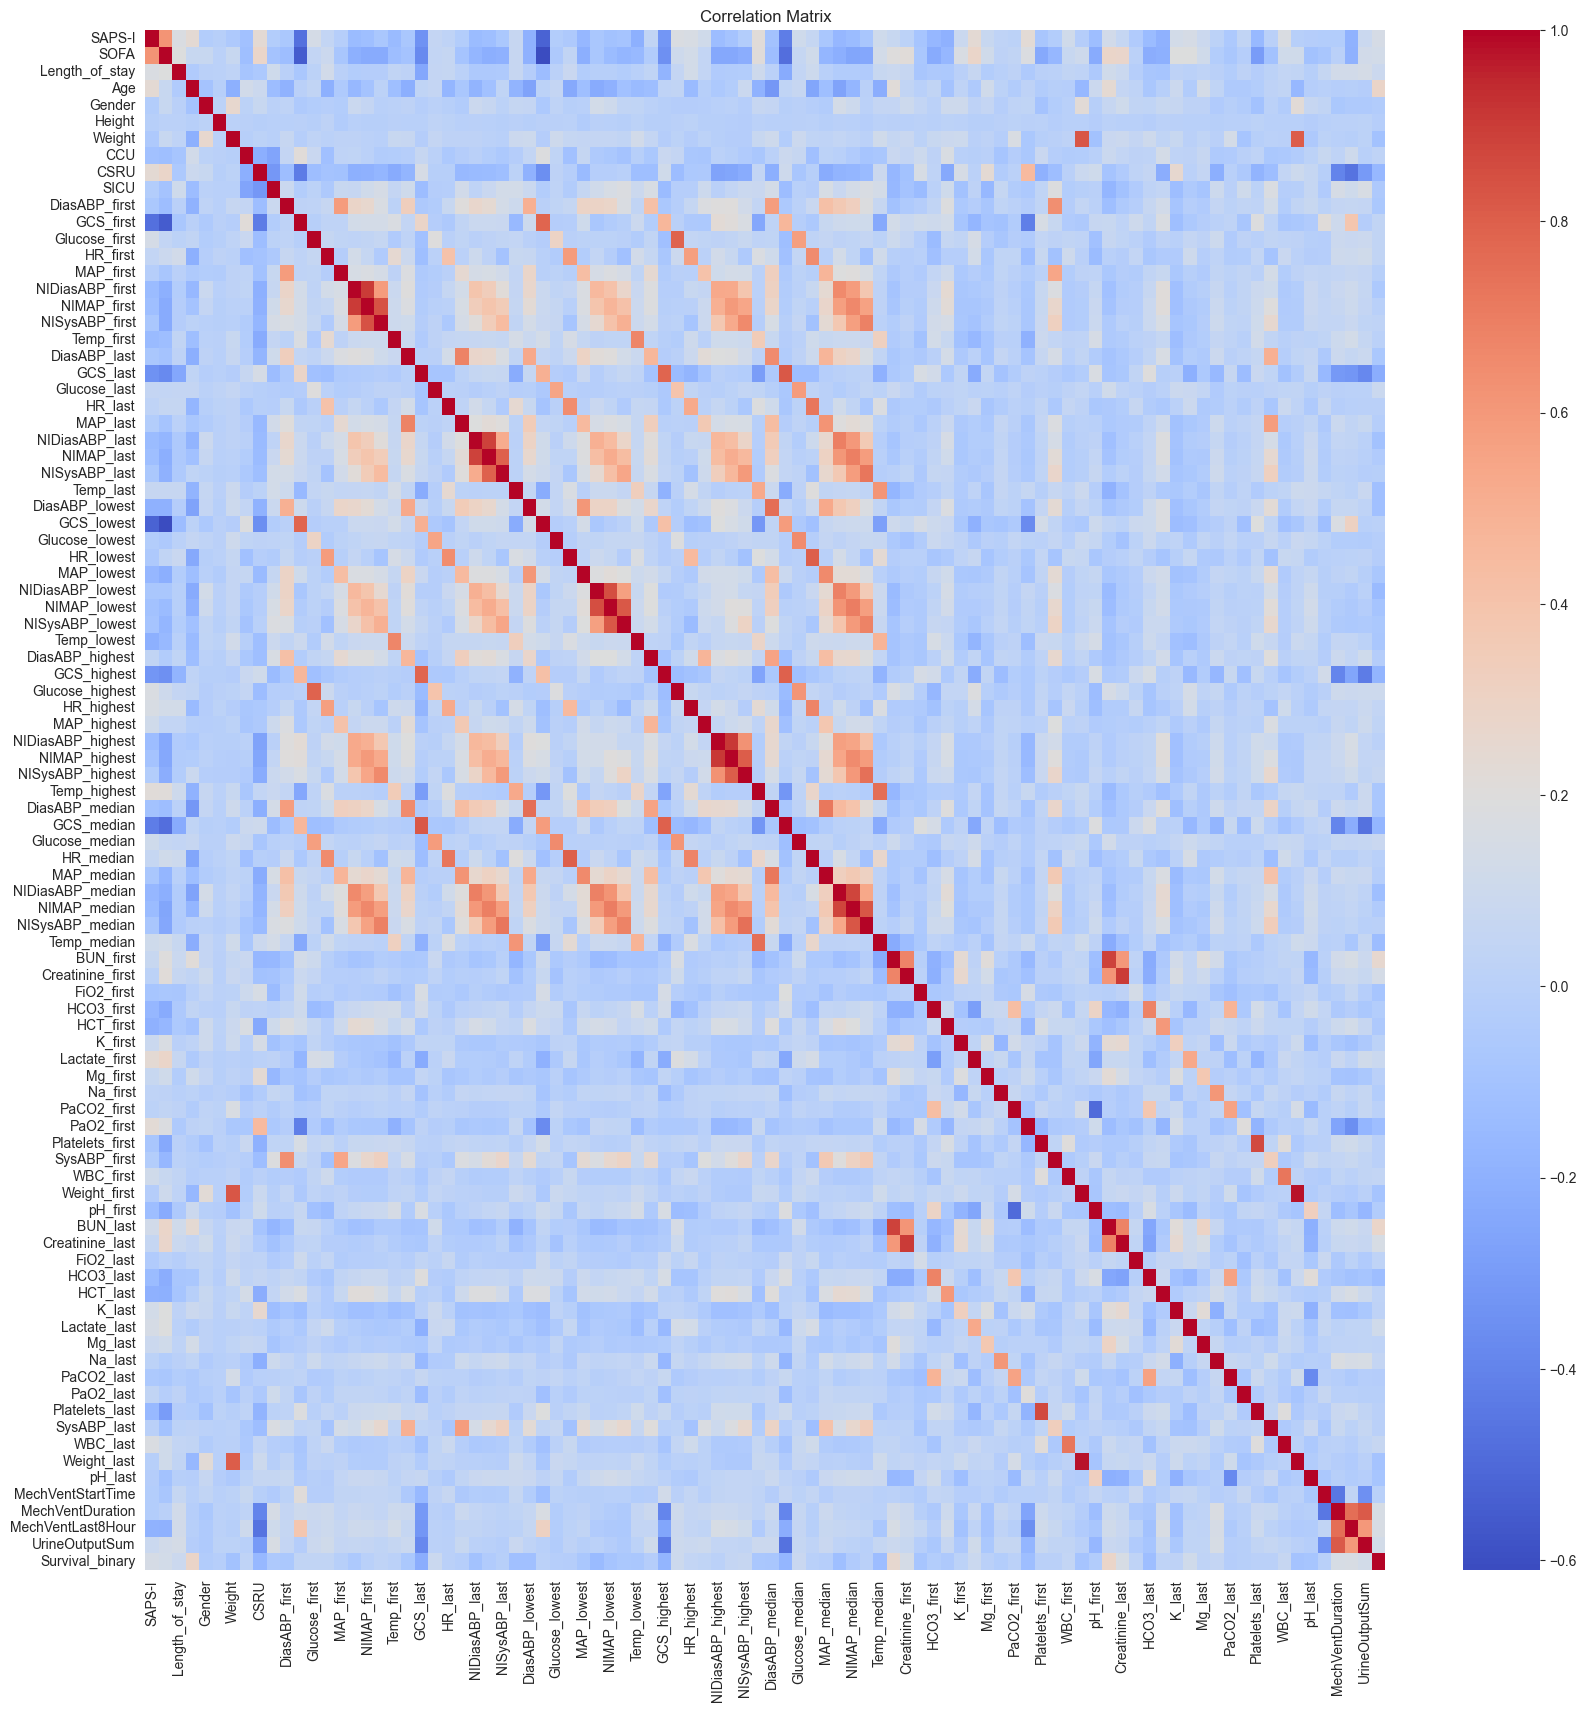

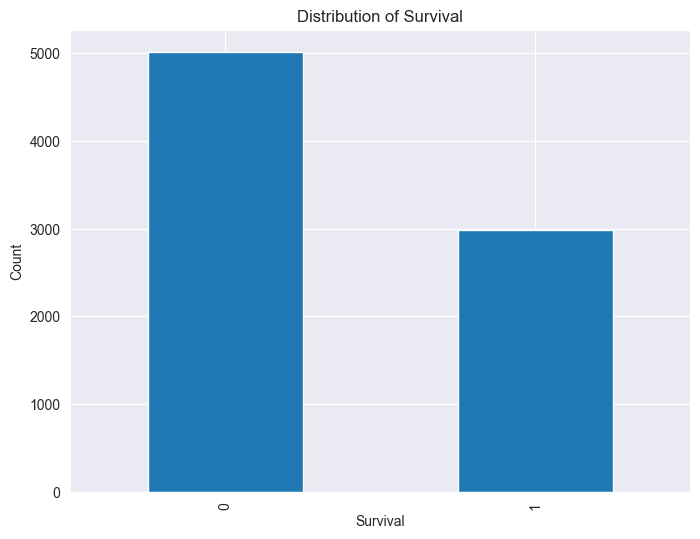

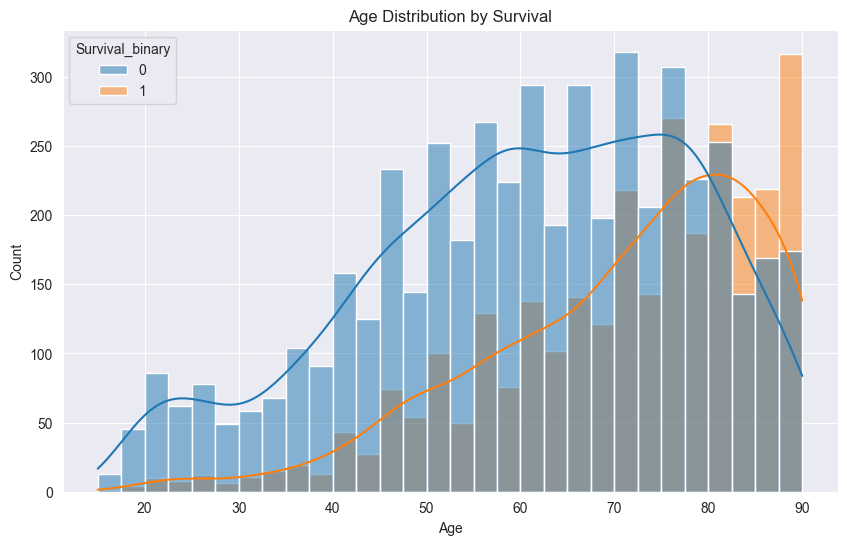

In [3]:
# Basic statistics
print(df.describe())

# Correlation matrix
corr_matrix = df.corr()
plt.figure(figsize=(20, 20))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

# Distribution of target variable
plt.figure(figsize=(8, 6))
df['Survival_binary'].value_counts().plot(kind='bar')
plt.title('Distribution of Survival')
plt.xlabel('Survival')
plt.ylabel('Count')
plt.show()

# Age distribution
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='Age', hue='Survival_binary', kde=True)
plt.title('Age Distribution by Survival')
plt.show()


Feature Selection

In [4]:
# Select top K features
X = df.drop('Survival_binary', axis=1)
y = df['Survival_binary']

selector = SelectKBest(score_func=f_classif, k=20)
X_new = selector.fit_transform(X, y)

selected_features = X.columns[selector.get_support()].tolist()
print("Top 20 selected features:", selected_features)

# Update dataframe with selected features
df_selected = df[selected_features + ['Survival_binary']]


Top 20 selected features: ['SAPS-I', 'SOFA', 'Age', 'CSRU', 'GCS_last', 'DiasABP_lowest', 'NIDiasABP_lowest', 'GCS_highest', 'GCS_median', 'NIDiasABP_median', 'Temp_median', 'BUN_first', 'Creatinine_first', 'PaO2_first', 'BUN_last', 'Creatinine_last', 'HCO3_last', 'MechVentDuration', 'MechVentLast8Hour', 'UrineOutputSum']


Data Preprocessing

In [5]:
# Split the data
X = df_selected.drop('Survival_binary', axis=1)
y = df_selected['Survival_binary']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


Model Selection and Training

In [6]:
# Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)


RandomForestClassifier(random_state=42)

Model Evaluation

Accuracy: 0.714375

Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.82      0.78      1013
           1       0.63      0.53      0.58       587

    accuracy                           0.71      1600
   macro avg       0.69      0.68      0.68      1600
weighted avg       0.71      0.71      0.71      1600



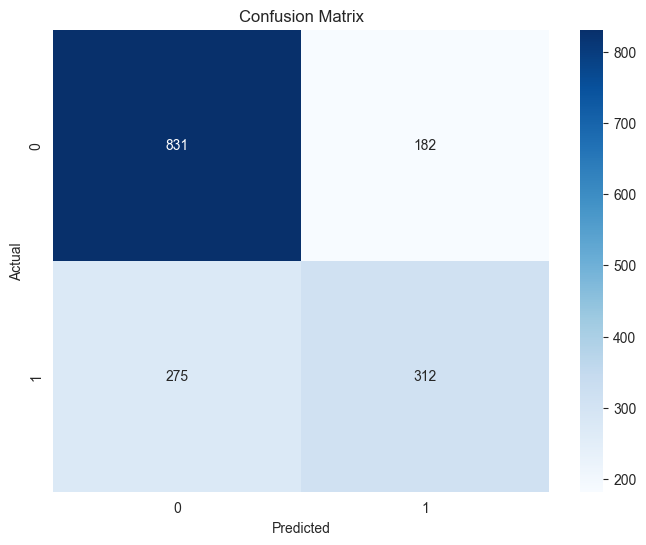

In [7]:
# Make predictions
y_pred = rf_model.predict(X_test_scaled)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

Feature Importance Analysis

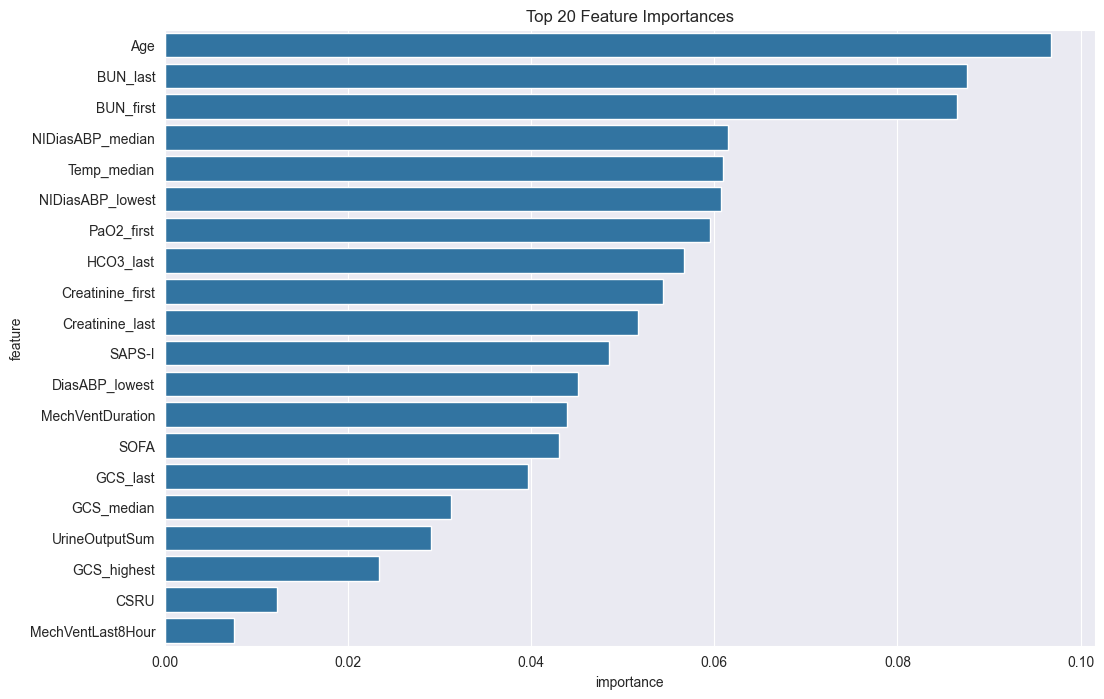

In [8]:
# Get feature importances
importances = rf_model.feature_importances_
feature_importance = pd.DataFrame({'feature': X.columns, 'importance': importances})
feature_importance = feature_importance.sort_values('importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(12, 8))
sns.barplot(x='importance', y='feature', data=feature_importance.head(20))
plt.title('Top 20 Feature Importances')
plt.show()